In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, TimeDistributed
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, calculate_diffs
from tools import to_timeseries
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Configuration

In [2]:
SEQUENCE_SIZE = 32
BATCH_SIZE = 1024

# Data

In [3]:
dataset = load_household_power_consumption(hour_one_hot=True)
data_x, data_y = split_x_y(dataset, SEQUENCE_SIZE)
diff_x, diff_y = split_x_y(calculate_diffs(dataset), SEQUENCE_SIZE)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x, diff_x, t=SEQUENCE_SIZE), 
    to_timeseries(data_y, diff_y, t=SEQUENCE_SIZE), 
    train_ratio=0.8)

display(dataset[['active_power', 'reactive_power', 'voltage', 'intensity', 'sub1',
                 'sub2', 'sub3', 'h_0', 'h_1', 'h_23']].head())


print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print()
print('diff_x:', diff_x.shape)
print('diff_y:', diff_y.shape)
print()
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print()
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-28 22:07:15,427 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,h_0,h_1,h_23
datetime,,,,,,,,,,
2010-10-27 13:40:00,0.596,0.000,246.50,2.6,0.0,0.0,0.0,0,0,0
2010-10-27 13:41:00,0.576,0.000,247.09,2.4,0.0,0.0,1.0,0,0,0
2010-10-27 13:42:00,0.524,0.084,247.52,2.2,0.0,0.0,1.0,0,0,0
2010-10-27 13:43:00,0.524,0.084,247.45,2.2,0.0,0.0,0.0,0,0,0
2010-10-27 13:44:00,0.520,0.086,246.33,2.2,0.0,0.0,1.0,0,0,0


data_x: (43579, 31)
data_y: (43579, 1)

diff_x: (43579, 1)
diff_y: (43579, 1)

train_x: (34258, 64, 31)
train_y: (34258, 64, 1)

test_x: (8565, 64, 31)
test_y: (8565, 64, 1)


파란색 그래프가 보이면 안됩니다.
파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거


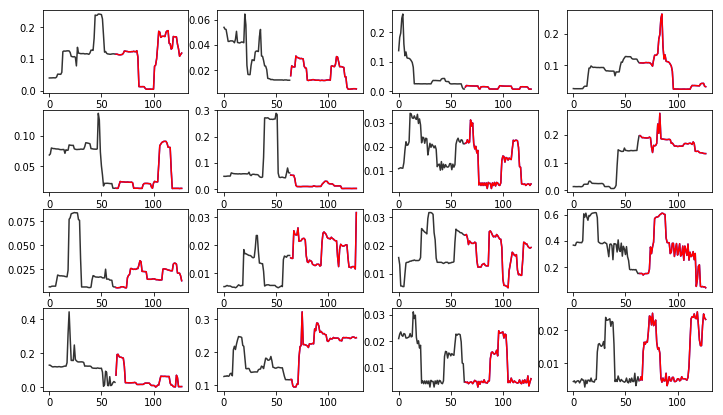

In [4]:
def vis_dataset(x, y):
    n = x.shape[0]
    seq_n = x.shape[1]
    
    fig, plots = pylab.subplots(4, 4)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    plots = plots.reshape(-1)

    for p in plots:
        idx = np.random.randint(0, n)
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n*2)
        
        p.plot(x1, x[idx, :, 0], label='input', color='#333333')
        p.plot(x2, x[idx+SEQUENCE_SIZE, :, 0], label='output', color='blue')
        p.plot(x2, y[idx, :, 0], label='output', color='red')

print('파란색 그래프가 보이면 안됩니다.')
print('파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거')
vis_dataset(train_x, train_y)

# Models

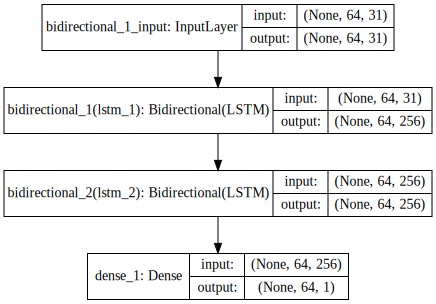

In [5]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64, n_input=31):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(LSTM(l1, return_sequences=True), input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Bidirectional(LSTM(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model

model = create_model(128, 128)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [ ]:
model = create_model(l1=256, l2=256, n_input=31)

history = History()
model.fit(train_x, train_y, epochs=50, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34258 samples, validate on 8565 samples
Epoch 1/50
26s - loss: 0.0121 - acc: 0.0000e+00 - r2: -1.0662e-01 - val_loss: 0.0061 - val_acc: 1.1675e-04 - val_r2: 0.1817
Epoch 2/50
25s - loss: 0.0070 - acc: 0.0000e+00 - r2: 0.3564 - val_loss: 0.0053 - val_acc: 1.1675e-04 - val_r2: 0.3218
Epoch 3/50
25s - loss: 0.0063 - acc: 0.0000e+00 - r2: 0.4177 - val_loss: 0.0051 - val_acc: 1.1675e-04 - val_r2: 0.3597
Epoch 4/50
25s - loss: 0.0057 - acc: 0.0000e+00 - r2: 0.4771 - val_loss: 0.0050 - val_acc: 1.1675e-04 - val_r2: 0.3557
Epoch 5/50
25s - loss: 0.0056 - acc: 0.0000e+00 - r2: 0.4862 - val_loss: 0.0049 - val_acc: 1.1675e-04 - val_r2: 0.3734
Epoch 6/50
25s - loss: 0.0051 - acc: 0.0000e+00 - r2: 0.5329 - val_loss: 0.0047 - val_acc: 1.1675e-04 - val_r2: 0.4025
Epoch 7/50
25s - loss: 0.0048 - acc: 0.0000e+00 - r2: 0.5584 - val_loss: 0.0053 - val_acc: 1.1675e-04 - val_r2: 0.3088
Epoch 8/50
25s - loss: 0.0045 - acc: 9.1220e-07 - r2: 0.5891 - val_loss: 0.0052 - val_acc: 1.1675e-04 - val_r2: 0

# Evaluation

In [8]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 1.99 s, sys: 408 ms, total: 2.4 s
Wall time: 2.18 s
loss: 0.006797719963429897
acc: 0.00011675423234092235
r2: -0.111973893677221


[3753] r^2: -2.595      
[5988] r^2: -2.408      
[6295] r^2: 0.5369      
[7186] r^2: -1.058      
[3998] r^2: -3.689      
[264 ] r^2: -0.5962     
[5057] r^2: -0.1858     
[1470] r^2: -3.955      
[3345] r^2: -1.584      
[6795] r^2: -32.81      
[1081] r^2: -8.267      
[3957] r^2: -11.64      
[190 ] r^2: -3.443      
[8154] r^2: -0.08473    
[263 ] r^2: -0.5822     
[3874] r^2: 0.4545      


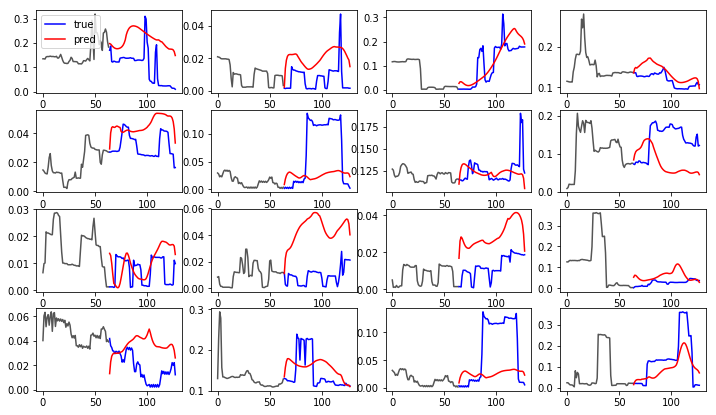

In [7]:
vis_evaluate(model, test_x, test_y, batch=2048)